## Overview
Small expiriment visualizing fixed basis functions in regression problems. I take a classification problem, fit it with chosen non-linear basis functions for the input features and a logistic regression model. Then I transfor the input space from the $x_1, x_2$ basis to that defined by the chosen basis functions $\phi_1, \phi_2$. Finally, I plot the decision boundary fitted by the logistic regression model within this new coordinate system. This demonstrates the linearity of GLMs within the feature space (i.e. the space defined by the basis functions $\phi_1$ & $\phi_2$) despite being non-linear in the input space (i.e. the space defined by the inputs $x_2$ & $x_2$).

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


def logit(x): return np.log(x / (1 - x))
def sigmoid(x): return 1 / (1 + np.exp(-x))

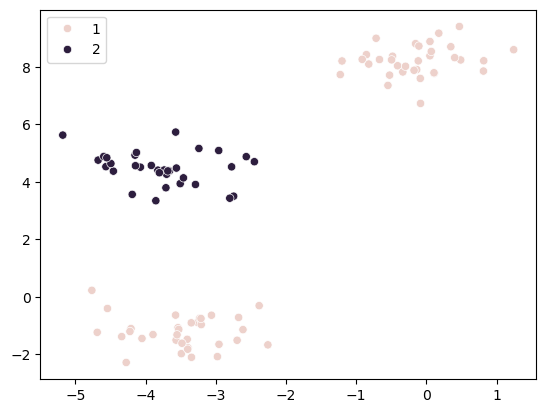

In [71]:
X, y = make_blobs(n_samples=100, centers=3, n_features=2, cluster_std=0.6)
x1, x2 = X[:, 0], X[:, 1]
y[y == 0] = 1
sns.scatterplot(x=x1, y=x2, hue=y);

Accuracy: 0.96


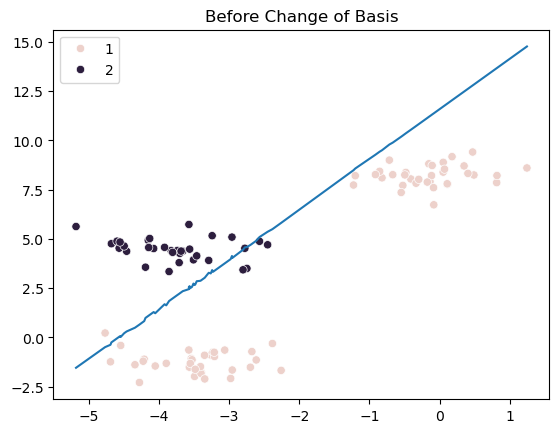

In [74]:
mod = LogisticRegression(penalty=None)
mod.fit(X, y)
print(f"Accuracy: {accuracy_score(y, mod.predict(X))}")

h = mod.predict_proba(X)[:, 1]
b = mod.intercept_
w1, w2 = mod.coef_[0]

# h = w1 * phi1 + w2 * phi2 + b
h = sigmoid(h)
fx2 = (h - w1 * x1 - b) / w2

plt.title("Before Change of Basis")
sns.scatterplot(x=x1, y=x2, hue=y)
sns.lineplot(x=x1, y=fx2);

Accuracy: 1.0


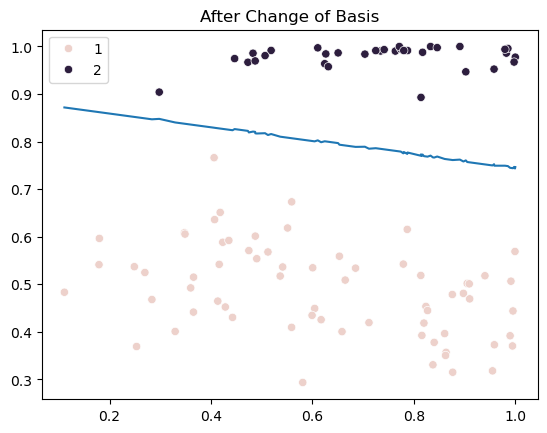

In [ ]:
# Gaussian basis functions
def gauss_basis(x):
    return np.exp(-((x - x.mean(axis=0))**2) / (2 * x.var(axis=0)))

phi1 = gauss_basis(x1)
phi2 = gauss_basis(x2)

mod = LogisticRegression(penalty=None)
Xg = gauss_basis(X)
mod.fit(Xg, y);

print(f"Accuracy: {accuracy_score(y, mod.predict(Xg))}")

h = mod.predict_proba(Xg)[:, 1]
b = mod.intercept_
w1, w2 = mod.coef_[0]

# h = w1 * phi1 + w2 * phi2 + b
h = sigmoid(h)
fx2 = (h - w1 * phi1 - b) / w2

plt.title("After Change of Basis")
sns.scatterplot(x=phi1, y=phi2, hue=y)
sns.lineplot(x=phi1, y=fx2);

I believe the reason that this is not a perfectly straight line is due to sklearn parameters, possibly related to its optimization algorithms.

The basis function used in these examples was the *Gaussian Basis* function, defined as:
$$\phi(x) = \text{exp}\bigg( \frac{-(x-\mu)^2}{2\sigma^2} \bigg)$$
This basis function has some desirable properties:
- They have derivatives of all orders (super smooth)
- They can easily be combined to create complex spaces (analagous to Gaussian Mixtures) through Gaussian basis expansion

They have some downsides too, specifically:
- They are *non-homeomorphic*
    - Not Injective because $x=-2$ and $x=2$ will map to the same value
    - Not continuously invertible because of the term $-(x - \mu)^2$

So, we cannot easily get back to the $x_1, x_2$ space after mapping into the $\phi_1, \phi_2$ space... If we could easily convert back, then we would see that the decision boundary plotted above would appear as a ring around the class $2$ blob in the first scatterplot.

Let's look at some homeomorphic basis functions:

In [153]:
# sigmoidal basis function
def sig_basis(x):
    res = (x - x.mean(axis=0)) / x.std(axis=0)
    return  sigmoid(res)

# hyperbolic tangent basis function
def tanh_basis(x):
    return 2 * sigmoid(2 * x) - 1


def decision_boundary(X, y):
    mod = LogisticRegression(penalty=None)
    mod.fit(X, y)
    acc = accuracy_score(y, mod.predict(X))

    h = mod.predict_log_proba(X)[:, 1]
    b = mod.intercept_
    w1, w2 = mod.coef_[0]
    h = sigmoid(h)

    return (h - w1 * X[:, 0] - b) / w2, acc


def print_plot(X2, y):
    fx, acc = decision_boundary(X, y)
    fx2, acc2 = decision_boundary(X2, y)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.set_title(f"Before Change of Basis, Acc: {acc:,.2f}")
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, ax=ax1)
    sns.lineplot(x=X[:, 0], y=fx, ax=ax1)

    ax2.set_title(f"After Change of Basis, Acc: {acc2:,.2f}")
    sns.scatterplot(x=X2[:, 0], y=X2[:, 1], hue=y, ax=ax2)
    sns.lineplot(x=X2[:, 0], y=fx2, ax=ax2)
    plt.show();

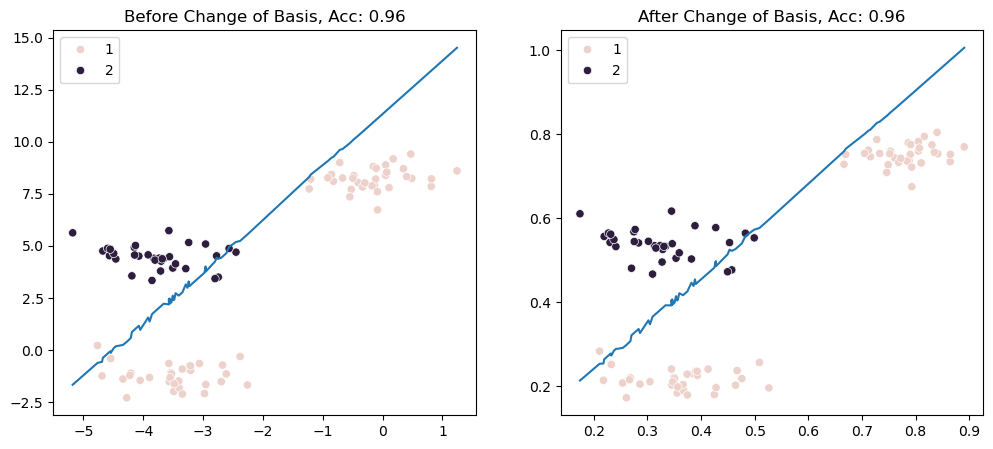

In [154]:
print_plot(sig_basis(X), y)

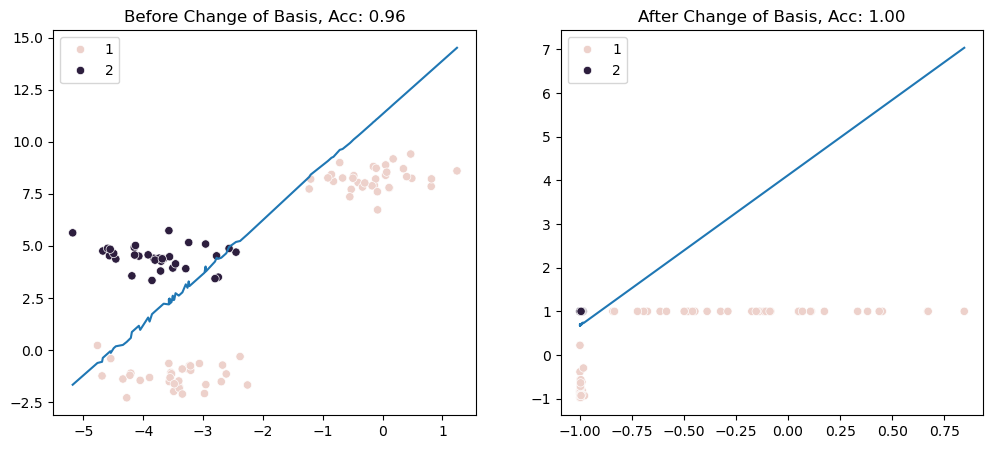

In [155]:
print_plot(tanh_basis(X), y)

Lets reverse this `tanh` basis to see the decision boundary in $x_1, x_2$:

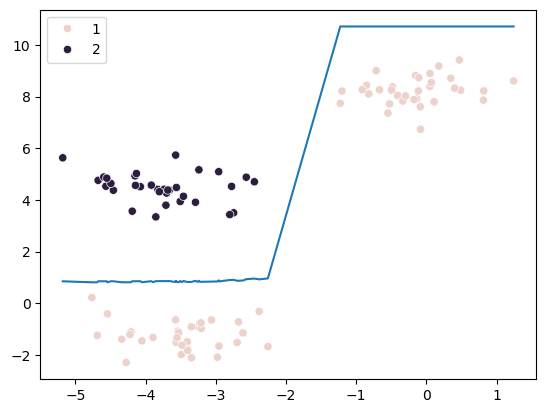

In [171]:
def inv_tanh(x):
    return logit((x + 1) / 2) / 2

fx2 = decision_boundary(tanh_basis(X), y)[0]
fx2[fx2 > 1] = 0.999999999
fx2[fx2 < -1] = -0.9999999

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
sns.lineplot(x=X[:, 0], y=inv_tanh(fx2));

This is important! The range of the `tanh` function (i.e. the codomain of its image) is $(-1, 1)$. So, the `tanh` "change of basis" squashes all of our data points into a region of $\reals^2$ bounded by $\phi_1 \in (-1, 1)$ and $\phi_2 \in (-1, 1)$. However, the decision boundary fit by the logistic regression algorithm *is not bound to this region* is a 1-dimensional subspace of $\reals^2$ and thus has a range of all real numbers. So, converting this decision boundary back to the $x_1, x_2$ coordinate-system requires that we truncate the values of the decision boundary outside $(-1, 1)$ before applying the `inv_tanh` function. Without this truncation, we will get errors at the extrema.